In [18]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [19]:
# %cd drive/MyDrive/Colab_Notebooks/Image_Classification/Covid19-dataset

# Chest X-Ray Image Classification

This project intends to explore different `scikit-learn` models and their accuracy of predicting whether a person's chest x-ray suggests that they are healthy, have Covid-19, or viral pneumonia. Two datasets are used: [training data](https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia) and [holdout data](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset).

The project explores three different models, SVM, decision trees, and neural nets. 

## Model: SVM Classifier

The first model to explore is the SVM classifier. Characteristics of SVM classifiers include:
* **Not** susceptible to the curse of dimensionality
* Always possible to find an optimal solution
* Data needs to be scaled
* Hyperparameters can be tuned with cross-validation

In [7]:
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import pickle 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Step 1: Data Collection

The data from the Kaggle dataset is already cleaned, with "clusters of defective images are removed during the curation process and a refined dataset is obtained which is available for download." All that is left to do regarding the data is to collect it and reshape it into a way that can be processed by the SVM classifier.

This involves:
* Assigning labels
* Reading and resizing images 
* Flattening images 

It is imperative to resize the images, as processing very large images can be difficult, especially if we're treating each pixel as a feature. Also, flattening the images (2D array) into a 1D array makes it possible to pass into a SVM classifier.

#### 1A. Assigning labels
Function to return a label associated with a given path. If the path does not exist, raise an `exception`

In [8]:
def get_label_from_path(path):
  if "COVID-19" in path:
    return "Covid"
  elif "Normal" in path:
    return "Normal"
  elif "Pneumonia-Viral" in path:
    return "Pneumonia-Viral"
  else:
    raise Exception("Path does not contain a valid feature label: ", path)

#### 1B. Reading and Resizing Images
Function to read images from a folder given a path and resize them

In [9]:
def collect_images(path, total_features, total_labels):
  temp_files = []
  [temp_files.extend(glob.glob(path + '*.' + e)) for e in ext]
  temp_images = [cv2.imread(file) for file in temp_files]
  resized_images = []
  for image in temp_images:
    resized_images.append(cv2.resize(image, (100, 100)))
    total_labels.append(get_label_from_path(path))
  total_features.extend(resized_images)

Utilize the `collect_images` and `get_label_from_path` methods to read in images from the **Curated-dataset**.

Keep a collection of all the images and their features.

Temporarily keep a train and test split (80-20) to model a small classifier later.

In [13]:
train_paths = ["Curated-dataset/COVID-19/", "Curated-dataset/Normal/", "Curated-dataset/Pneumonia-Viral/"]
# test_paths = ["test/Covid/", "test/Normal/", "test/Viral_Pneumonia/"]
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
all_images = []
all_labels = []

# Collect all images from Curated-dataset
for path in train_paths:
  collect_images(path, all_images, all_labels)

# After collecting all images, randomize them
temp_arr = []
for i in range(len(all_images)):
  temp_arr.append((all_images[i], all_labels[i]))
random.shuffle(temp_arr)
for i in range(len(all_images)):
  all_images[i] = temp_arr[i][0]
  all_labels[i] = temp_arr[i][1]

# Temporarily keep a partition of training data and testing data
FIFTH_OF_DATA = int(0.2 * len(all_images))
train_images = all_images[: 4 * FIFTH_OF_DATA]
train_labels = all_labels[: 4 * FIFTH_OF_DATA]
test_images = all_images[4 * FIFTH_OF_DATA:]
test_labels = all_labels[4 * FIFTH_OF_DATA:]

Verify the dimensions of the data

In [14]:
print("Training data: ", len(train_images), len(train_labels))
print("Testing data: ", len(test_images), len(test_labels))
print("All data: ", len(all_images), len(all_labels))

Training data:  4964 4964
Testing data:  1243 1243
All data:  6207 6207


Function that prints out the avg dimensions of a set of images.

In [15]:
def print_dimensions(images):
  average_x = 0
  average_y = 0
  min_x = 1000000
  min_y = 1000000
  train_len = len(images)
  for image in images:
    dimension = image.shape
    average_x += dimension[0]
    min_x = min(min_x, dimension[0])
    if(len(dimension) > 1):
      average_y += dimension[1]
      min_y = min(min_y, dimension[1])
  print("Average width: ", average_x / train_len)
  print("Min width: ", min_x)
  if(len(dimension) > 1):
    print("Average height: ", average_y / train_len)
    print("Min height: ", min_y, "\n")

Ensure that the images have been resized correctly to be *100x100*

In [16]:
print("Train image information: ")
print_dimensions(train_images)

Train image information: 
Average width:  100.0
Min width:  100
Average height:  100.0
Min height:  100 



Visualize a few of the training images to see what the computer would see. An observation is that the general shapes of things remain intact and are not particularly distorted. Some details may be obfuscated.

<class 'numpy.ndarray'>


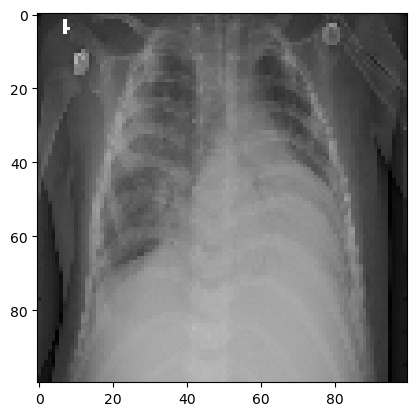

<class 'numpy.ndarray'>


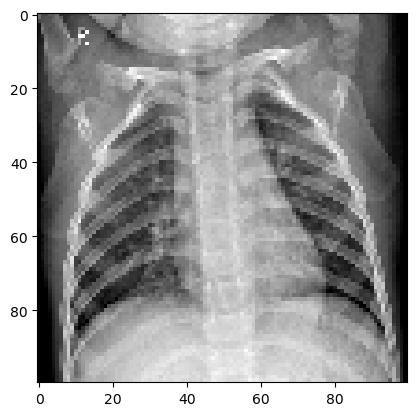

<class 'numpy.ndarray'>


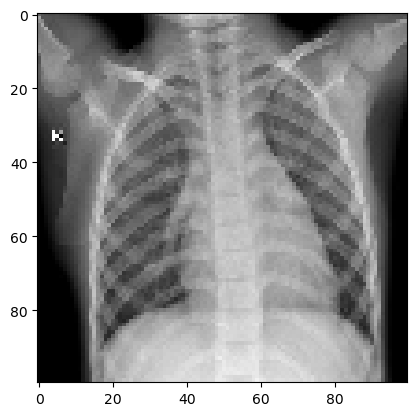

In [17]:
for i in range(3):
  random_img = random.choice(train_images)
  print(type(random_img))
  plt.imshow(random_img, interpolation='nearest')
  plt.show()

#### 1C. Flattening Images

Create a method to flatten an array of images. Apply that to `train_images`, `test_images`, and `all_images`

Function to flatten collection of 2D arrays into 1D arrays

In [22]:
def flatten_images(images):
  for i in range(len(images)):
    images[i] = np.reshape(images[i], -1)

### Step 2: Cross-Validation

To find the best parameters and verify the process of using an SVM classifier, we will use cross-validation. 

This involves:
* Creating a Pipeline for the data
* Running a nested cross-validation loop
* Creating a final model

We need to create a pipeline to try different ways to scale the data, different ways to project features to lower dimensions, and try different classifiers. The nested cross-validation loop will help verify the accuracy of the classifier and partition the data automatically. Once the process has been deemed valid, we can create a final model.

#### 2A. Create a Pipeline for the Data

Create a StandardScaler object, PCA object, and Pipeline which takes the aforementioned objects. These will be used with a param grid that will try pca `__n_components` from 5-18 and svc `__kernel`'s, `linear`, `rbf`, and `poly`. These will be passed into a `GridSearchCV` object to create the inner-loop of the cross-validation loop with folds = 5. 

In [35]:
# flatten each collection of images
flatten_images(train_images)
flatten_images(test_images)
flatten_images(all_images)

scaler = StandardScaler()
pca = PCA()
svc_classifier = SVC()
svc_pipeline = Pipeline(steps = [('scaler', scaler), 
                                 ('pca', pca), 
                                 ('svc', svc_classifier)])

svc_param_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

#### 2B. Run Nested Cross-Validation Loop

Pass the inner_svm, which is scaled, using PCA, and will try various params into a `cross_val_score`, which will produce the results of the outer cross-validation loop with folds = 5. Pass in the entire dataset, as these methods will automatically partition the data. This will take a decent amount of time, as there are 10,000 features per image (100 x 100), and the number of models to train.

When it's complete, print the average accuracy.

In [36]:
# Test a singular classifier trained on a single partition
svc_classifier.fit(train_images, train_labels)
predictions = svc_classifier.predict(test_images)
print("Accuracy with holdout: ", 
      accuracy_score(test_labels, predictions))

# Create the inner cross-validation loop with a cv = 5
inner_svm = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
# Run outer cross-validation loop with cv = 5
fold_accuracies = cross_val_score(inner_svm, 
                                  all_images, 
                                  all_labels, 
                                  cv = 5)
print("Svc accuracy: ", sum(fold_accuracies) / len(fold_accuracies))

Accuracy with holdout:  0.9517296862429606
Svc accuracy:  0.9347525046680707


#### 2C. Create a Final Model

Given that the cross-validation loop had a relatively high accuracy, it is safe to say that the SVM model is appropriate for classifying X-ray images. Fit the inner-loop on all the data, and display the best hpyerparameters and its overall accuracy.

In [37]:
final_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
final_svc.fit(all_images, all_labels)

print("Best_params: ", final_svc.best_params_)
print("Accuracy: ", final_svc.best_score_)
filename = 'final_svc_model.sav'

Best_params:  {'pca__n_components': 18, 'svc__kernel': 'rbf'}
Accuracy:  0.9347525046680707


#### Important!
Dump final model to save a lot of work!

In [38]:
pickle.dump(final_svc, open(filename, 'wb'))

### Step 3: Testing Model on Unseen Data
It's important for our model to be accurate on unseen data. Otherwise, our model is not very useful, as it is unfit for evaluating new data. Thus, the next step is to test it on another [dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), and evaluate its performance thusly.

We can evaluate its effective accuracy through:
* Confusion Matrix
* F-Score
* General Accuracy

In [29]:
# Load in the images from the holdout set
holdout_paths = ["Covid19-dataset/test/COVID-19/", 
                 "Covid19-dataset/test/Normal/", 
                 "Covid19-dataset/test/Pneumonia-Viral/",
                 "Covid19-dataset/train/COVID-19/",
                 "Covid19-dataset/train/Normal/",
                 "Covid19-dataset/train/Pneumonia-Viral/"]
holdout_images = []
holdout_labels = []
for path in holdout_paths:
    collect_images(path, holdout_images, holdout_labels)

#### 3A. Confusion Matrix

Flatten the holdout images and display the Confusion Matrix given the holdout labels and predictions.

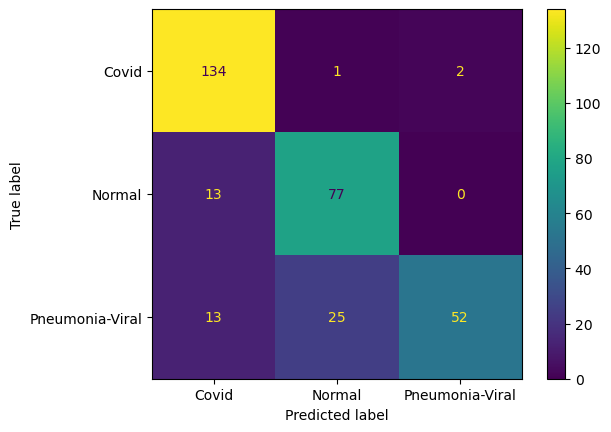

In [30]:
flatten_images(holdout_images)
predictions = loaded_model.predict(holdout_images)
ConfusionMatrixDisplay.from_predictions(holdout_labels, predictions)

#### 3B. General Accuracy

Display the percentage of records that the model predicts correctly.

In [33]:
accuracy = accuracy_score(holdout_labels, predictions)
print("Total accuracy on different dataset: ", accuracy * 100, "%")

Total accuracy on different dataset:  82.96529968454259 %


#### 3C. F-Score
Display the F-score of the model

### Conclusion for SVM Classifiers

The SVM classifiers seem to do a good job at classifying whether someone has Covid-19, viral pneumonia, or is healthy given a large number X-ray images to train on. It took a few hours to do the cross-validation, and that could probably be decremented by resizing the images to smaller dimensions at the expense of some accuracy. 

One problematic thing with the model's prediction is that it has a non-trivial amount of false-negatives for viral pneumonia. This possibly be countered if we applied a cost matrix that punished false-negatives.